In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import albumentations as A
from tqdm import tqdm
import segmentation_models_pytorch as smp
from transformers import SegformerForSemanticSegmentation
from transformers import SegformerImageProcessor
import json
from huggingface_hub import hf_hub_download
from PIL import Image
from torch import nn
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn


In [ ]:
!pip install segmentation-models-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
if torch.cuda.is_available():
    print("GPU is available!")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU is available!
GPU Name: NVIDIA A100-SXM4-40GB


In [ ]:
metadata = pd.read_csv('/content/drive/MyDrive/Road_ID_images/metadata.csv')
metadata.head()

,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png


In [ ]:
metadata = metadata[metadata['split']=='train']
len(metadata)


6226

In [ ]:
images = []
masks = []
for i in tqdm(range(6226)):
    path='/content/drive/MyDrive/Road_ID_images/'
    # print(metadata['sat_image_path'][i])
    image = plt.imread(path+metadata['sat_image_path'][i])

    mask = plt.imread(path+metadata['mask_path'][i])


    image = cv2.resize(image,(128,128),interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mask,(128,128),interpolation=cv2.INTER_CUBIC)
    # mask = cv2.resize(mask,(128,128))
    # image = cv2.resize(image(128,128))
    grayimg = mask[:,:,0]*0.2989+mask[:,:,1]*0.5870+mask[:,:,2]*0.1140
    images.append(image)
    masks.append(grayimg)

100%|██████████| 6226/6226 [2:50:32<00:00,  1.64s/it]


In [ ]:
def get_augmentations(image_size = 128, crop_prob = 1):
    return A.Compose([

        A.RandomCrop(width = image_size, height = image_size, p=crop_prob),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.25),
    ],p=1)

In [ ]:
timgs,tmasks = images.copy(),masks.copy()
for image,mask in tqdm(zip(images,masks)):
    aug = get_augmentations()(image=image,mask=mask)
    timgs.append(aug['image'])
    tmasks.append(aug['mask'])

6226it [00:01, 3148.52it/s]


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(timgs,tmasks,test_size=0.05,random_state=42)

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
def dice_score(pred, target, epsilon=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice.mean()

def iou_score(pred, target, epsilon=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou.mean()

class SatelliteDataset(Dataset):
    def __init__(self, images, masks, augmentation=None):
        self.images = images
        self.masks = masks
        self.augmentation = augmentation

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Transform to tensor and add channel dimension to mask
        return torch.from_numpy(image.transpose(2, 0, 1)).float(), torch.from_numpy(mask).float().unsqueeze(0)

In [ ]:
train_dataset = SatelliteDataset(X_train, y_train, augmentation=get_augmentations())
test_dataset = SatelliteDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
import segmentation_models_pytorch as smp
road_labels = {
  "0": "not_road",
  "1": "road",
}
road_label2id = {v: k for k, v in road_labels.items()}


# load id2label mapping from a JSON on the hub
# think we might need to adjust the num_labels and the id2label situation to fit out specific case
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}


model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=2,
                                                         id2label=road_labels,
                                                         label2id=road_label2id,
)
# Move the model to the configured device
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = smp.losses.SoftBCEWithLogitsLoss()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ade20k-id2label.json:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_losses, val_losses, train_dice_scores, val_dice_scores, train_iou_scores, val_iou_scores = [], [], [], [], [], []

for epoch in range(25):  # Adjust the number of epochs as necessary
    model.train()
    total_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        images = images[:, :, :, :]
        masks_new = masks[:, 0, :, :]
        masks_long = masks_new.to(torch.long)
        final_masks = torch.cat([masks, masks], dim=1)

        outputs = model(pixel_values=images, labels=masks_long)
        logits = outputs.logits
        logits_resized = torch.nn.functional.interpolate(logits, size=(128, 128), mode='bilinear', align_corners=False)
        loss = loss_func(logits_resized, final_masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    train_dice_scores.append(dice_score(logits_resized, masks).item())
    train_iou_scores.append(iou_score(logits_resized, masks).item())

    # # Validation phase
    # model.eval()
    # total_val_loss, val_dice, val_iou = 0, [], []
    # with torch.no_grad():
    #     for images, masks in tqdm(test_loader):
    #         images, masks = images.to(device), masks.to(device)
    #         outputs = model(images)
    #         val_loss = loss_func(logits_resized, masks)
    #         total_val_loss += val_loss.item()
    #         val_dice.append(dice_score(outputs, masks).item())
    #         val_iou.append(iou_score(outputs, masks).item())
    #     val_losses.append(total_val_loss / len(test_loader))
    #     val_dice_scores.append(np.mean(val_dice))
    #     val_iou_scores.append(np.mean(val_iou))
    print(train_losses)
    print(train_dice_scores)
    print(train_iou_scores)
    # print(f'Epoch {epoch}: Train Loss: {train_losses[epoch]}, Val Loss: {val_losses[epoch]}, Train Dice: {train_dice_scores[epoch] if train_dice_scores else 0}')
    #, Val Dice: {val_dice_scores[-1] if val_dice_scores else 0}, Train IoU: {train_iou_scores[-1] if train_iou_scores else 0}, Val IoU: {val_iou_scores[-1] if val_iou_scores else 0}')


100%|██████████| 740/740 [00:31<00:00, 23.79it/s]


[0.11513811038756692]
[0.4277677536010742]
[0.3077542781829834]


100%|██████████| 740/740 [00:31<00:00, 23.80it/s]


[0.11513811038756692, 0.11438998969120753]
[0.4277677536010742, 0.1441168487071991]
[0.3077542781829834, 0.08532200008630753]


100%|██████████| 740/740 [00:31<00:00, 23.28it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115]


100%|██████████| 740/740 [00:31<00:00, 23.25it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057]


100%|██████████| 740/740 [00:32<00:00, 23.03it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323]


100%|██████████| 740/740 [00:31<00:00, 23.22it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624]


100%|██████████| 740/740 [00:31<00:00, 23.22it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294]


100%|██████████| 740/740 [00:31<00:00, 23.35it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294, 0.1558752954006195]


100%|██████████| 740/740 [00:31<00:00, 23.82it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294, 0.1558752954006195, 0.1944887489080429]


100%|██████████| 740/740 [00:30<00:00, 23.88it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294, 0.1558752954006195, 0.1944887489080429, 0.38810229301452637]


100%|██████████| 740/740 [00:30<00:00, 23.91it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294, 0.1558752954006195, 0.1944887489080429, 0.38810229301452637, 0.33013033866882324]


100%|██████████| 740/740 [00:31<00:00, 23.76it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294, 0.1558752954006195, 0.1944887489080429, 0.38810229301452637, 0.33013033866882324, 0.17506623268127441]


100%|██████████| 740/740 [00:31<00:00, 23.70it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786, 0.10779764945241245]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708, 0.48685985803604126]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294, 0.1558752954006195, 0.1944887489080429, 0.38810229301452637, 0.33013033866882324, 0.17506623268127441, 0.3809002637863159]


100%|██████████| 740/740 [00:31<00:00, 23.41it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786, 0.10779764945241245, 0.10721692477629798]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708, 0.48685985803604126, 0.1778905838727951]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294, 0.1558752954006195, 0.1944887489080429, 0.38810229301452637, 0.33013033866882324, 0.17506623268127441, 0.3809002637863159, 0.10922356694936752]


100%|██████████| 740/740 [00:31<00:00, 23.70it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786, 0.10779764945241245, 0.10721692477629798, 0.10701039815573274]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708, 0.48685985803604126, 0.1778905838727951, 0.39049243927001953]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294, 0.1558752954006195, 0.1944887489080429, 0.38810229301452637, 0.33013033866882324, 0.17506623268127441, 0.3809002637863159, 0.10922356694936752, 0.3391593396663666]


100%|██████████| 740/740 [00:31<00:00, 23.86it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786, 0.10779764945241245, 0.10721692477629798, 0.10701039815573274, 0.1069595017143198]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708, 0.48685985803604126, 0.1778905838727951, 0.39049243927001953, 0.3335009515285492]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294, 0.1558752954006195, 0.1944887489080429, 0.38810229301452637, 0.33013033866882324, 0.17506623268127441, 0.3809002637863159, 0.10922356694936752, 0.3391593396663666, 0.23324699699878693]


100%|██████████| 740/740 [00:31<00:00, 23.72it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786, 0.10779764945241245, 0.10721692477629798, 0.10701039815573274, 0.1069595017143198, 0.10615760993615196]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708, 0.48685985803604126, 0.1778905838727951, 0.39049243927001953, 0.3335009515285492, 0.49013957381248474]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294, 0.1558752954006195, 0.1944887489080429, 0.38810229301452637, 0.33013033866882324, 0.17506623268127441, 0.3809002637863159, 0.10922356694936752, 0.3391593

100%|██████████| 740/740 [00:31<00:00, 23.70it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786, 0.10779764945241245, 0.10721692477629798, 0.10701039815573274, 0.1069595017143198, 0.10615760993615196, 0.1059162141604198]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708, 0.48685985803604126, 0.1778905838727951, 0.39049243927001953, 0.3335009515285492, 0.49013957381248474, 0.45315858721733093]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294, 0.1558752954006195, 0.1944887489080429, 0.38810229301452637, 0.33013033866882324, 0.17506623268127441, 0.3809002

100%|██████████| 740/740 [00:31<00:00, 23.73it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786, 0.10779764945241245, 0.10721692477629798, 0.10701039815573274, 0.1069595017143198, 0.10615760993615196, 0.1059162141604198, 0.10590642632262127]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708, 0.48685985803604126, 0.1778905838727951, 0.39049243927001953, 0.3335009515285492, 0.49013957381248474, 0.45315858721733093, 0.33076247572898865]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294, 0.1558752954006195, 0.1944887489080429, 0.38810229301452637, 0.3301303

100%|██████████| 740/740 [00:31<00:00, 23.80it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786, 0.10779764945241245, 0.10721692477629798, 0.10701039815573274, 0.1069595017143198, 0.10615760993615196, 0.1059162141604198, 0.10590642632262127, 0.10504531723421973]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708, 0.48685985803604126, 0.1778905838727951, 0.39049243927001953, 0.3335009515285492, 0.49013957381248474, 0.45315858721733093, 0.33076247572898865, 0.11167281121015549]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614875078201294, 0.1558752954006195, 0.194488

100%|██████████| 740/740 [00:30<00:00, 23.98it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786, 0.10779764945241245, 0.10721692477629798, 0.10701039815573274, 0.1069595017143198, 0.10615760993615196, 0.1059162141604198, 0.10590642632262127, 0.10504531723421973, 0.10511313035983491]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708, 0.48685985803604126, 0.1778905838727951, 0.39049243927001953, 0.3335009515285492, 0.49013957381248474, 0.45315858721733093, 0.33076247572898865, 0.11167281121015549, 0.45321837067604065]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.16935212910175323, 0.284656286239624, 0.38614

100%|██████████| 740/740 [00:31<00:00, 23.58it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786, 0.10779764945241245, 0.10721692477629798, 0.10701039815573274, 0.1069595017143198, 0.10615760993615196, 0.1059162141604198, 0.10590642632262127, 0.10504531723421973, 0.10511313035983491, 0.10476981249914781]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708, 0.48685985803604126, 0.1778905838727951, 0.39049243927001953, 0.3335009515285492, 0.49013957381248474, 0.45315858721733093, 0.33076247572898865, 0.11167281121015549, 0.45321837067604065, 0.2841225266456604]
[0.3077542781829834, 0.08532200008630753, 0.23096103966236115, 0.10559282451868057, 0.1693

100%|██████████| 740/740 [00:31<00:00, 23.69it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786, 0.10779764945241245, 0.10721692477629798, 0.10701039815573274, 0.1069595017143198, 0.10615760993615196, 0.1059162141604198, 0.10590642632262127, 0.10504531723421973, 0.10511313035983491, 0.10476981249914781, 0.10468979086223486]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708, 0.48685985803604126, 0.1778905838727951, 0.39049243927001953, 0.3335009515285492, 0.49013957381248474, 0.45315858721733093, 0.33076247572898865, 0.11167281121015549, 0.45321837067604065, 0.2841225266456604, 0.21784530580043793]
[0.3077542781829834, 0.08532200008630753, 0.2309

100%|██████████| 740/740 [00:31<00:00, 23.75it/s]


[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786, 0.10779764945241245, 0.10721692477629798, 0.10701039815573274, 0.1069595017143198, 0.10615760993615196, 0.1059162141604198, 0.10590642632262127, 0.10504531723421973, 0.10511313035983491, 0.10476981249914781, 0.10468979086223486, 0.10427065377903952]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708, 0.48685985803604126, 0.1778905838727951, 0.39049243927001953, 0.3335009515285492, 0.49013957381248474, 0.45315858721733093, 0.33076247572898865, 0.11167281121015549, 0.45321837067604065, 0.2841225266456604, 0.21784530580043793, 0.37068042159080505]
[0.307

100%|██████████| 740/740 [00:31<00:00, 23.31it/s]

[0.11513811038756692, 0.11438998969120753, 0.11311856375856175, 0.11221243244772022, 0.1116900834582142, 0.11104603390637281, 0.110239308800649, 0.1095217409971598, 0.10970089596167609, 0.10895247100474867, 0.10836573149505499, 0.10792800211221786, 0.10779764945241245, 0.10721692477629798, 0.10701039815573274, 0.1069595017143198, 0.10615760993615196, 0.1059162141604198, 0.10590642632262127, 0.10504531723421973, 0.10511313035983491, 0.10476981249914781, 0.10468979086223486, 0.10427065377903952, 0.10381895274527975]
[0.4277677536010742, 0.1441168487071991, 0.26868435740470886, 0.17745693027973175, 0.2689209580421448, 0.3807015120983124, 0.5119359493255615, 0.25219041109085083, 0.29334425926208496, 0.5418686270713806, 0.38678795099258423, 0.2793676555156708, 0.48685985803604126, 0.1778905838727951, 0.39049243927001953, 0.3335009515285492, 0.49013957381248474, 0.45315858721733093, 0.33076247572898865, 0.11167281121015549, 0.45321837067604065, 0.2841225266456604, 0.21784530580043793, 0.3706

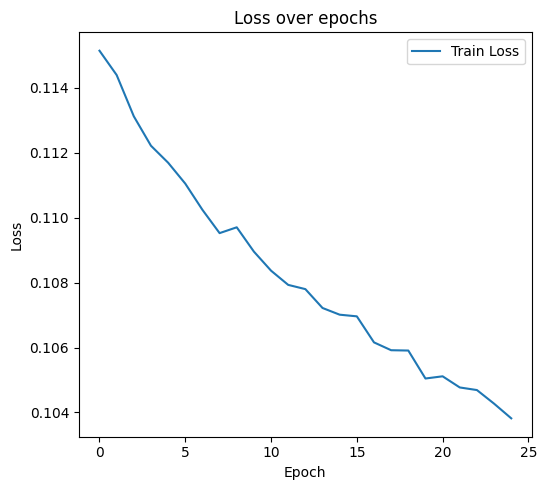

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
#plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

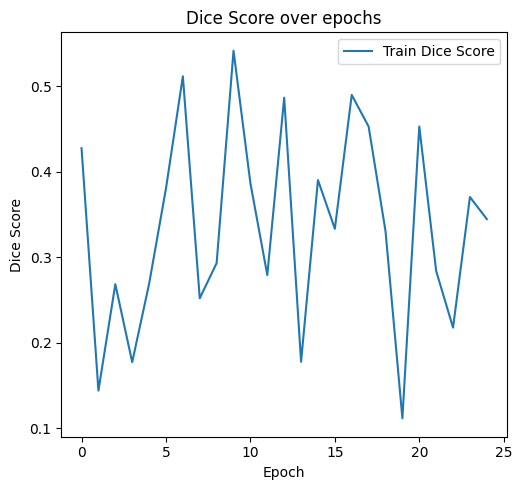

In [ ]:
# Plotting Dice score
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 2)
plt.plot(train_dice_scores, label='Train Dice Score')
#plt.plot(val_dice_scores, label='Validation Dice Score')
plt.title('Dice Score over epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.tight_layout()
plt.show()


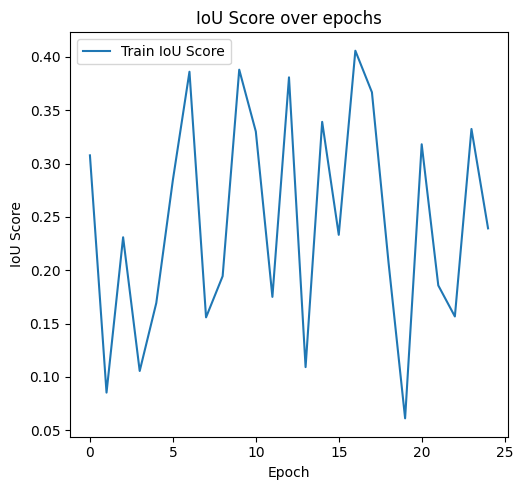

In [ ]:
# Plotting IoU score
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 3)
plt.plot(train_iou_scores, label='Train IoU Score')
# plt.plot(val_iou_scores, label='Validation IoU Score')
plt.title('IoU Score over epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()
plt.tight_layout()
plt.show()

16
16
1
(2, 32, 32)
(2, 32, 32)
(2, 32, 32)
(2, 32, 32)
(2, 32, 32)


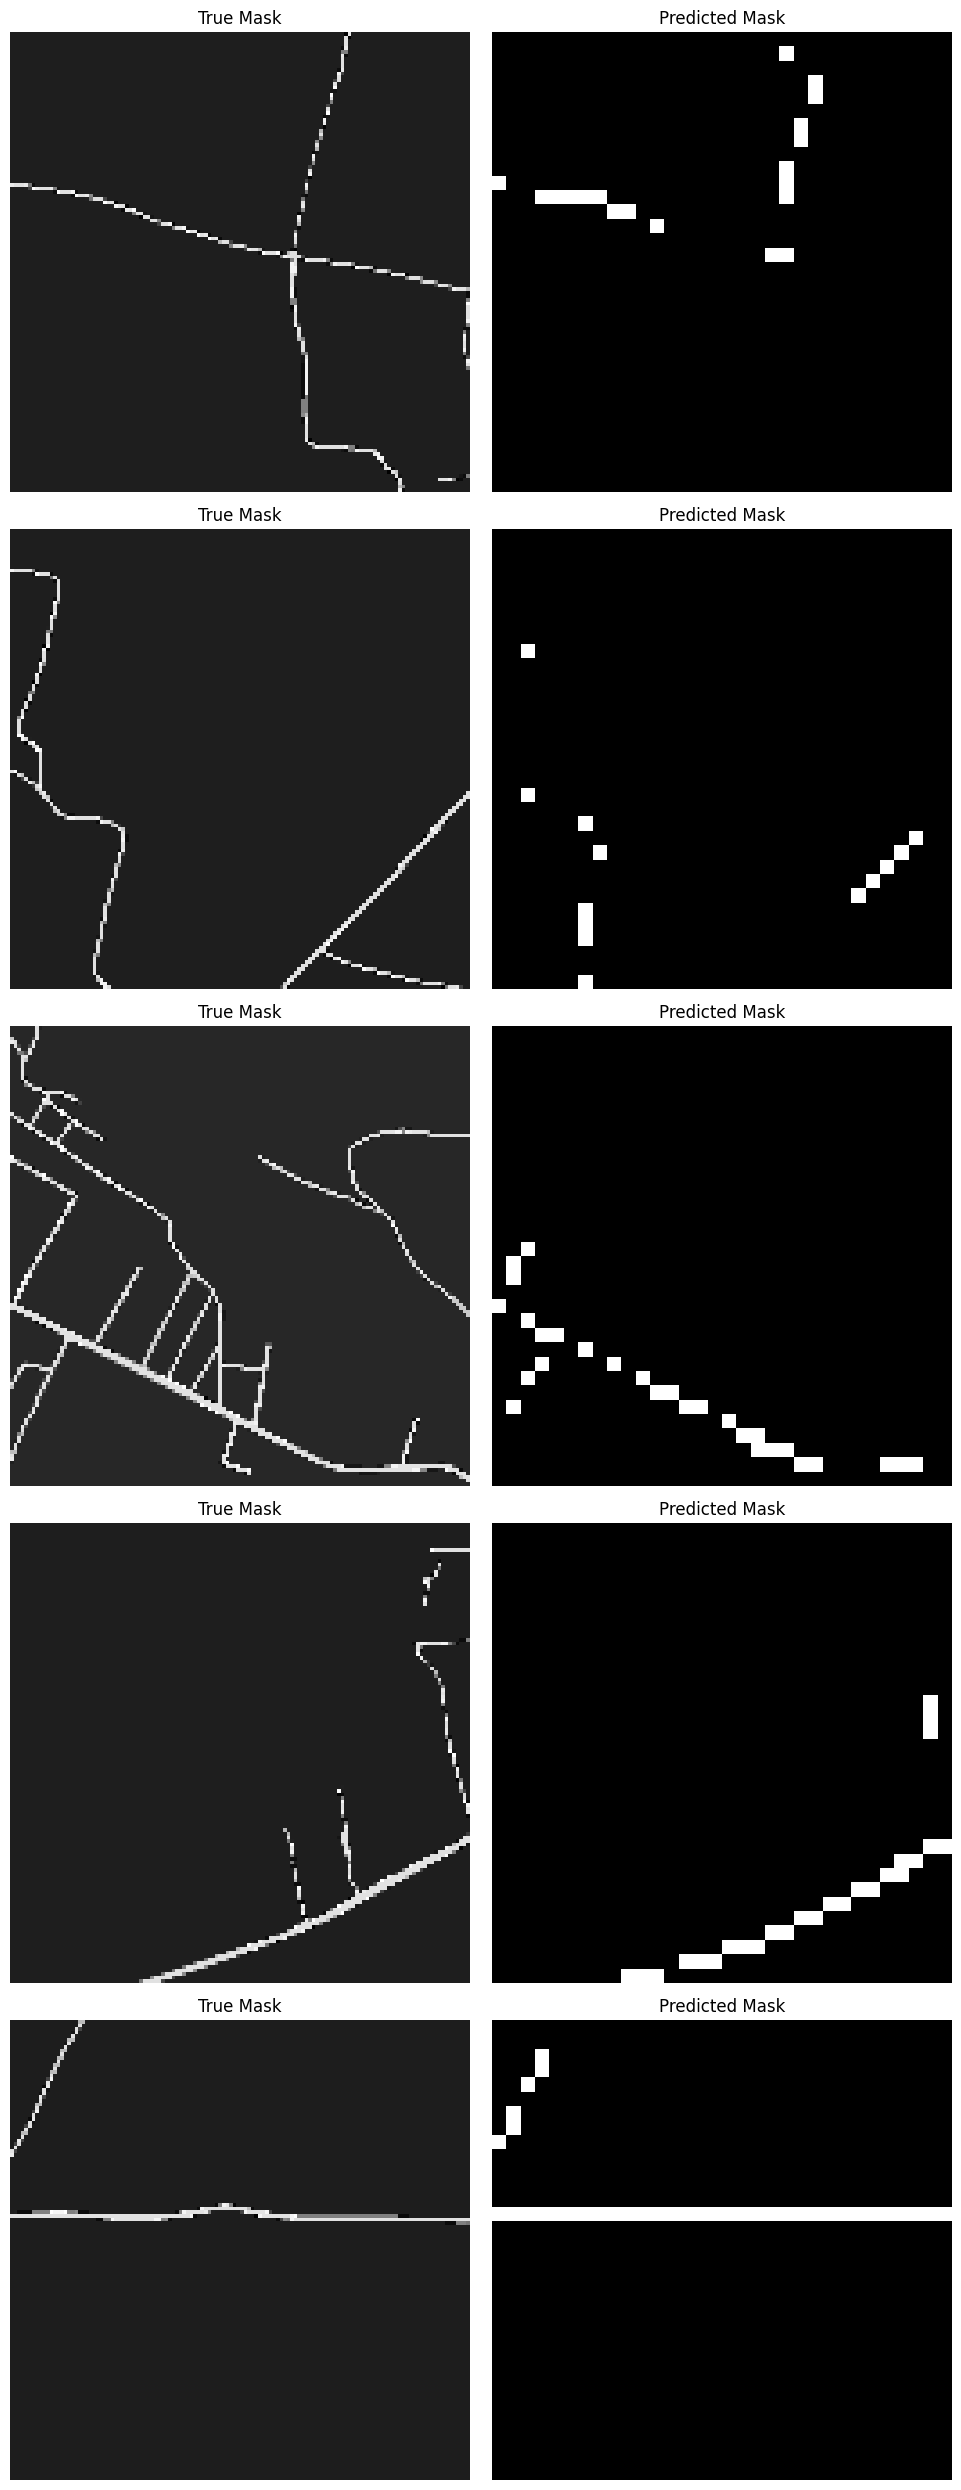

In [ ]:
# Set the model to evaluation mode
model.eval()

# Fetch a batch of data from the test_loader
test_images, test_masks = next(iter(test_loader))

# Move the test images and masks to the configured device
test_images = test_images.to(device)
test_masks = test_masks.to(device)

# Perform inference without calculating gradients
with torch.no_grad():
    predictions = model(test_images)
print(len(predictions.logits))
print(len(test_images))
print(len(predictions))
# Visualize the first few samples from the batch
num_samples = 5  # Adjust this number based on how many samples you want to visualize
fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))  # Adjust subplot grid for 2 columns instead of 3
for i in range(num_samples):
    true_mask = test_masks[i].cpu().numpy().squeeze()
    pred_mask = torch.sigmoid(predictions.logits[i]).cpu().numpy().squeeze() > 0.5  # Apply sigmoid and threshold
    print(pred_mask.shape)

    axs[i, 0].imshow(true_mask, cmap='gray')
    axs[i, 0].set_title('True Mask')
    axs[i, 0].axis('off')

    pred_mask = pred_mask[0, :, :]
    axs[i, 1].imshow(pred_mask, cmap='gray')
    axs[i, 1].set_title('Predicted Mask')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()